In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import scipy as sp
from scipy.integrate import odeint,quad,simps,trapz
from scipy.special import eval_hermite,eval_hermitenorm
from math import sqrt,sin,pi,cos,exp,log,factorial
from IPython.core.display import display, HTML
import sys
sys.path.append(r'/mnt/c/Users/Alejandro Lopez/Imperial College London/MSc Project - Alejandro López - MA - General/repository')
figures_route = r'/mnt/c/Users/Alejandro Lopez/Imperial College London/MSc Project - Alejandro López - MA - General/MSc Project - Latex/Figures/'
from nonparametric_generator import *
import matplotlib
def pgf_switch(setting = 'off'):
    if setting == 'off':
        matplotlib.use('module://ipykernel.pylab.backend_inline')
        matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': ['sans-serif'],
            'text.usetex': False,
            'pgf.rcfonts': True,
        })
    else:
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })

display(HTML("<style>.container { width:95% !important; }</style>"))

# Estimation of the operator $D^{-1}\mathcal{L}$

### 0. Data Simulation Euler–Maruyama method
\begin{align}
dX_t &= -X_t dt + \sqrt{2D}dW_t \\
X_0 &= 0 \\
X_{n+1} &= X_{n}-X_{n} \Delta t + \sqrt{2D} \Delta W_n \\
\Delta t &= 0.01 \\
\Delta W_n &\sim \mathcal{N}(0,\Delta t)\\
n &= 0,1,2,...,100000
\end{align}

In [2]:
def OUSimulation(x0, n,dt,D):
    """
    Function to create the trayectory of a OU process
    with difussion paramter D 

    :param x0: Intial position
    :param n:  Number of steps
    "param dt: Step size
    :param D:  Difussion parameter

    :return X: Trajectory
    """
    t = np.linspace(x0,dt*n,n)
    X = np.zeros((n,1))
    noise = np.random.normal(loc=0,scale=np.sqrt(dt),size=(n,1))
    for i in range(1,n):
        x = X[i-1,:]
        X[i,:] = x - x*dt +sqrt(2*D) * noise[i,:]
    return(X)

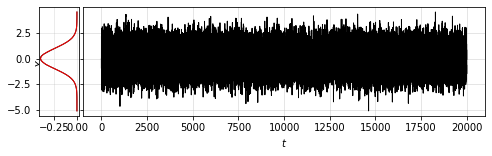

In [3]:
setting = 'off'
pgf_switch(setting)

x0 = 0
n = 2000000
dt = 0.01
T = dt*n
D = 1
np.random.seed(1)
X = OUSimulation(x0,n,dt,D)

gs1 = GridSpec(1, 2, width_ratios=[1,10],wspace=0.02,hspace=0.3)
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(gs1[1])
_ = ax1.plot(np.linspace(x0,n*dt,n), X[:,0],color='black',lw=1)
_ = ax1.grid(alpha=0.4)
_ = ax1.set_xlabel("$t$")
_ = ax1.set_ylabel("$X_t$")
# _ = ax1.set_title(f"Simulation, $T=$ {T:.0f}, $\Delta t =$ {dt}")
p_eq = density_estimation(X)
ax2 = fig.add_subplot(gs1[0])
_ = ax2.plot([-p_eq([x]) for x in np.linspace(min(X),max(X))],np.linspace(min(X),max(X)),color='k',lw=1)
_ = ax2.plot(-sp.stats.norm.pdf(np.linspace(min(X),max(X)),0,1),np.linspace(min(X),max(X)),color='r',lw=1)

_ = ax2.grid(alpha=0.3)
if setting == 'on':
    _ = plt.savefig(figures_route + '1dOUts.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

In [4]:
N = 5000
X_s = X[np.random.choice(range(n),size=N),:]

epsilon = 1.22e-03
d = 0.99


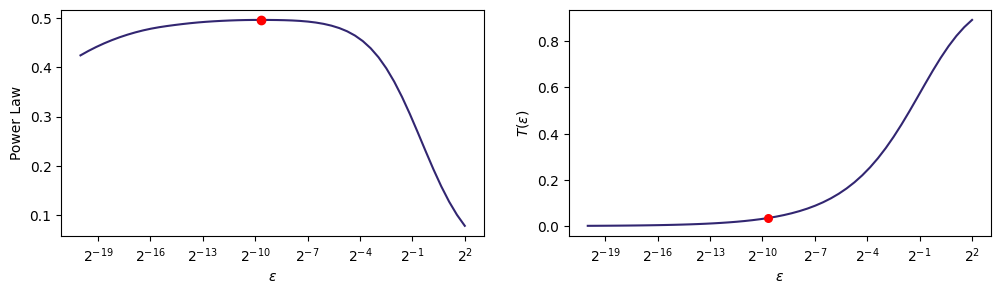

In [5]:
pgf_switch('off')
epsilon, d = bandwidth_search(X_s,plot=True,verbose=True)

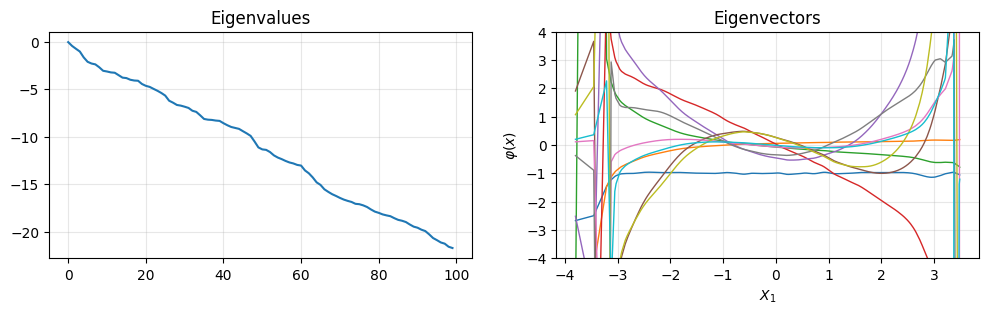

In [6]:
setting = 'off'
pgf_switch(setting)
l, phi,L_e, U = KNPGenerator(X_s,M=100,plot=True,return_extra=True)
phi_1 = np.linalg.pinv(phi)

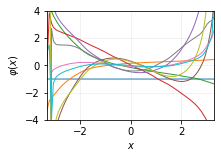

In [7]:
setting = 'off'
pgf_switch(setting)
plt.figure(figsize=(3,2))
for i in range(10):
    plt.plot(np.sort(X_s,axis=0),phi[:,i][np.argsort(X_s,axis=0)],lw=1)
plt.ylim(-4,4)
plt.grid(alpha=0.2)
plt.xlabel('$x$')
plt.ylabel('$\\varphi(x)$')
plt.xlim(-3.3,3.3)
if setting == 'on':
    _ = plt.savefig(figures_route + '1dOUeigenfunct_2.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

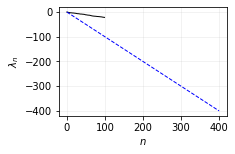

In [8]:
setting = 'off'
pgf_switch(setting)
plt.figure(figsize=(3,2))
plt.plot(l,color='k',lw=1)
plt.xlabel('$n$')
plt.ylabel('$\\lambda_n$')
plt.plot([0,400],[0,-400],color='b',ls='--',lw=1)
plt.grid(alpha=0.2)
if setting == 'on':
    _ = plt.savefig(figures_route + '1dOUeigenvalues_2.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

In [9]:
def Hermite(k,x,D):
    l_hermite = -(np.arange(0,k))
    phi_hermite = np.zeros((len(x),k))
    for ell in range(1,k+1):
        phi_hermite[:,ell-1] = (1/(factorial(ell-1)**0.5)) * eval_hermitenorm(ell-1,x*np.sqrt(1/D))
    return(l_hermite,phi_hermite)

l_hermite, phi_hermite =  Hermite(k=120,x=X_s[:,0],D=D)
L = phi_hermite @ np.diag(l_hermite) @ np.linalg.pinv(phi_hermite)

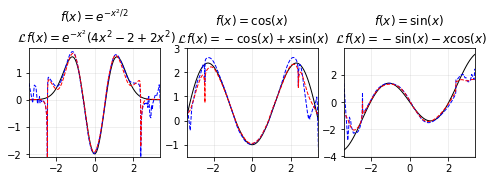

In [10]:
setting = 'off'
pgf_switch(setting)
fig,axs = plt.subplots(1,3,figsize=(8,2))
x = np.linspace(min(X_s),max(X_s),100)

Y = np.exp(-X_s[:,0]**2)
c_coef = (D/N)* Y@U
c_coef1 = (D) * phi_1 @ Y
axs[0].set_title("$f(x) =e^{-x^2/2} $ \n $\mathcal{L}f(x) = e^{-x^2}(4x^2-2+ 2x^2) $")
axs[0].plot(x, D*np.exp(-x**2)*(4*x**2-2) + 2*x**2*np.exp(-x**2),color='k',lw=1)
axs[0].plot(np.sort(X_s,axis=0),np.sum((c_coef*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='b',lw=1,ls='--')
axs[0].plot(np.sort(X_s,axis=0),np.sum((c_coef1*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='r',lw=1,ls='--')
# axs[0].scatter(X_s,D*L_e@Y,s=2,color='b')
# axs[0].scatter(X_s,L@Y,s=3,color='g')
axs[0].grid(alpha=0.25)
axs[0].set_ylim(-2.1,1.9)
axs[0].set_xlim(-3.4,3.4)

Y = np.cos(X_s[:,0])
c_coef =  (D/N)* Y@U
c_coef1 = (D) * phi_1 @ Y
axs[1].set_title("$f(x) =\cos(x) $ \n $\mathcal{L}f(x) = -\cos(x)+x\sin(x) $")
axs[1].plot(x,-D*np.cos(x) + x * np.sin(x),color='k',lw=1)
axs[1].plot(np.sort(X_s,axis=0),np.sum((c_coef*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='b',lw=1,ls='--')
axs[1].plot(np.sort(X_s,axis=0),np.sum((c_coef1*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='r',lw=1,ls='--')
# axs[1].scatter(X_s,D*L_e@Y,s=2,color='b')
# axs[1].scatter(X_s,L@Y,s=3,color='g')
axs[1].set_ylim(-1.5,3)
axs[1].set_xlim(-3.4,3.4)

axs[1].grid(alpha=0.25)

Y = np.sin(X_s[:,0])
c_coef =  (D/N)* Y@U
c_coef1 = (D) * phi_1 @ Y
axs[2].set_title("$f(x) =\sin(x) $ \n $\mathcal{L}f(x) = -\sin(x)-x\cos(x) $")
axs[2].plot(x,-D*np.sin(x) - x * np.cos(x),color='k',lw=1)
axs[2].plot(np.sort(X_s,axis=0),np.sum((c_coef*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='b',lw=1,ls='--')
axs[2].plot(np.sort(X_s,axis=0),np.sum((c_coef1*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='r',lw=1,ls='--')
# axs[2].scatter(X_s,D*L_e@Y,s=2,color='b',label='Multiplying by $L_{\epsilon}$')
# axs[2].scatter(X_s,L@Y,s=3,color='g',label='Using Hermite Polynomials')
axs[2].set_xlim(-3.4,3.4)
axs[2].grid(alpha=0.25)

if setting == 'on':
    _ = plt.savefig(figures_route +'1dOUtest_2.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

(-3.5, 3.5)

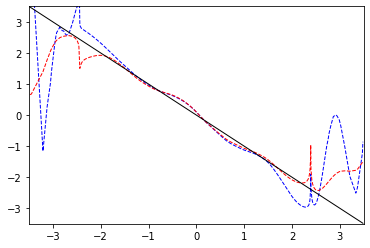

In [11]:
setting = 'off'
pgf_switch(setting)
Y = X_s[:,0]
c_coef =  (D/N)* Y@U
c_coef1 = (D) * phi_1 @ Y
plt.plot(np.sort(X_s,axis=0),np.sum((c_coef*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='b',lw=1,ls='--')
plt.plot(np.sort(X_s,axis=0),np.sum((c_coef1*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='r',lw=1,ls='--')
plt.plot(x, - x ,color='k',lw=1)
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)

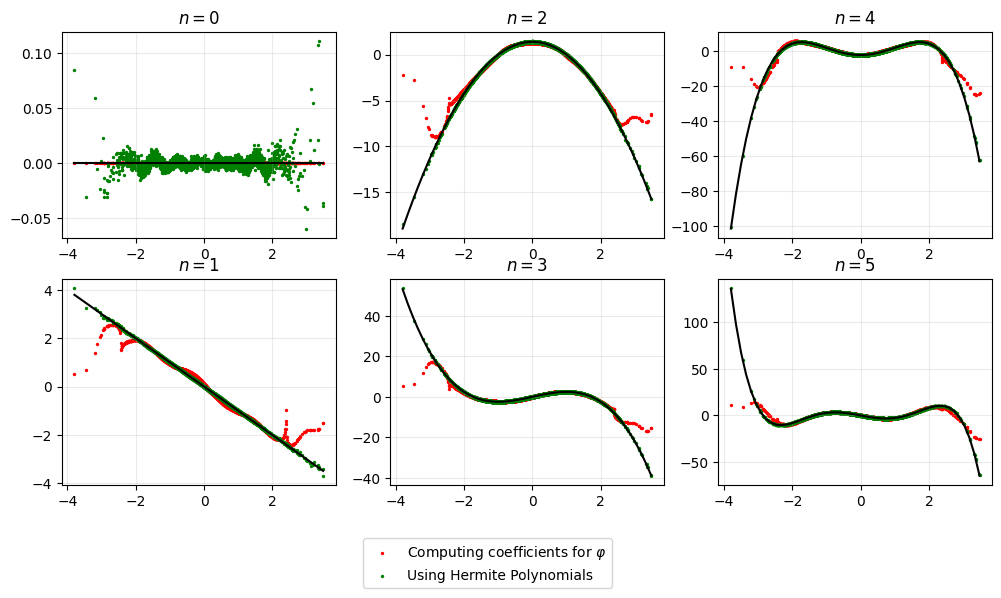

In [12]:
fig,axs = plt.subplots(2,3,figsize=(12,6),dpi=100)

for i,elle in enumerate([1,2,3,4,5,6]):
    Y = (1/(factorial(elle-1)**0.5)) * eval_hermitenorm(elle-1,X_s[:,0]*np.sqrt(1/D))
#     c_coef =  (D/N)* Y@U
    c_coef = (D) * phi_1 @ Y
    x = np.linspace(min(X_s),max(X_s))
    
    axs[i%2,int(i / 2)].set_title(f"$n = {i}$")
    axs[i%2,int(i / 2)].plot(x,-(elle-1)*(1/(factorial(elle-1)**0.5)) * eval_hermitenorm(elle-1,x*np.sqrt(1/D)),color='k')
    axs[i%2,int(i / 2)].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',label='Computing coefficients for $\\varphi$')
#     axs[i%2,int(i / 2)].scatter(X_s,D*L_e@Y,s=2,color='b',label='Multiplying by $L_{\epsilon}$')
    axs[i%2,int(i / 2)].scatter(X_s,L@Y,s=2,color='g',label='Using Hermite Polynomials')
    axs[i%2,int(i / 2)].grid(alpha=0.25)
axs[1,2].legend(loc=(-1.3,-0.5))

### 9. Compute a one dimensional observable $S$, for example $S(x(t)) = \sum_{i=1}^{n}((x(t))_i - \mathbb{E}((x(t))_i) $

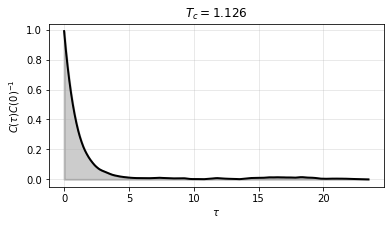

In [13]:
setting = 'off'
pgf_switch(setting)
S = np.sum(X - X.mean(),axis=1)
n = len(S)
C_tau=np.zeros(n)
C0 = (1/n) * np.sum(S**2)
for j in range(1,n):
    if 1/(n-j)*sum(S[:n-j]*S[j:]) > 0:
        C_tau[j] = 1/(n-j)*sum(S[:n-j]*S[j:])
    else:
        break
C_tau = C_tau[C_tau>0]
pv = len(C_tau)
Tc = simps(x=np.linspace(0,n*dt,n)[:pv],y= C_tau / C0)

_ = plt.figure(figsize=(6,3))
_ = plt.grid(alpha=0.35)
_ = plt.plot(np.linspace(0,n*dt,n)[:pv],C_tau / C0 ,color='k',lw=2)
_ = plt.fill_between(np.linspace(0,n*dt,n)[:pv],C_tau / C0 ,color='k',lw=2,alpha=0.2)
_ = plt.xlabel('$\\tau$')
_ = plt.ylabel('$C(\\tau) C(0)^{-1}$')
_ = plt.title(f'$T_c = {Tc:.3f}$')

 ### 11. Estimate D as $$D = -\frac{1}{T_c}\frac{\sum_{i=1}^M \lambda_i ^{-1}(S(x)^{\top}\varphi_i)^2}{\sum_{i=1}^M (S(x)^{\top}\varphi_i)^2} $$

In [14]:
S = np.sum(X_s - X_s.mean(),axis=1)
s1 = np.sum((1/l) * (S.T@phi)**2)
s2 = np.sum((S.T@phi)**2)
D = - (1/Tc)* (s1/s2)
D

1.0201622286815313

# Push-forward of a initial density $p_0(x)$

### 1. Estimate the initial condition $c_i(0)$ as $$\hat{c}_i(0)=\frac{1}{N}\sum_{j=1}^N \frac{p_0(x_j)}{\hat{p}_{\text{eq}}(x_j)}\varphi_i(x_j) $$

In [18]:
p_0 = np.vectorize(lambda x: sp.stats.expon.pdf(x,0))
p_eq = density_estimation(X_s)
rho_eq = np.vectorize(lambda x: p_eq(x)[0])
c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s))) * phi,axis=0)
init = 0
tf = 2
Nt = 100
tarray = np.linspace(0,tf,Nt)
csol = np.exp(tarray[:,None] * l[None,:] * D ) * c_0

### 2. Compute the numerical solution of the ODE $$\frac{\text{d} c}{\text{d} t} = D\Lambda c$$ with initial condition $\hat{c}_i(0)$

### 3. Using $M$ modes estimate the density  as $$\hat{p}(x,t) =\hat{p}_{\text{eq}}(x) \sum_{i=0}^M \hat{c}_i(t)\varphi_i(x)$$

In [16]:
p_transition = lambda x0,x,t: sp.stats.norm.pdf(x,loc=x0*np.exp(-t),scale = 1-np.exp(-2*t))*p_0(x0)

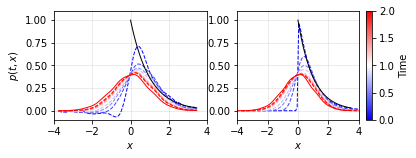

In [20]:
setting = 'off'
pgf_switch(setting)

X_sort = np.sort(np.ravel(X_s))
N = len(X_s)
dx = np.diff(X_sort)
fig, axs = plt.subplots(1, 2,figsize=(6,2))
for t in np.arange(1,100,12):
    est_density = p_eq(X_s.T)* np.sum(phi * csol[t],axis=1)

    est_density=est_density[np.argsort(np.ravel(X_s))]
    cum = trapz(x=X_sort,y= est_density.T)
    axs[0].plot(X_sort,(1/cum) *est_density,lw=1,color=plt.cm.bwr(t/100),ls='--')
    
    
axs[0].plot(np.linspace(min(X_s),max(X_s),100),p_eq(np.linspace(min(X_s),max(X_s),100).T),
         color='r',lw=1)
axs[0].plot(np.linspace(0,max(X_s),100),p_0(np.linspace(0,max(X_s),100)),
         color='k',lw=1)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$p(t,x)$')
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-0.1,1.1)
axs[0].grid(alpha=0.3)

fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0,2), cmap=plt.cm.bwr),ax= axs[1],label='Time')

for t in np.linspace(0,tf,Nt)[np.arange(1,100,12)]:
    N = 200
    x = np.linspace(-10,10,N)
    x0 = np.linspace(-10,10,N)
    pxt = np.zeros_like(x)
    for i in range(N):
        pxt[i] = trapz(x=x0,y=p_transition(x0,x[i],t))
    axs[1].plot(x,pxt/trapz(x=x,y=pxt) ,color=plt.cm.bwr(t/2),lw=1,ls='--')
    
    
axs[1].plot(np.linspace(min(X_s),max(X_s),100),p_eq(np.linspace(min(X_s),max(X_s),100).T),
         color='r',lw=1)
axs[1].plot(np.linspace(0,max(X_s),100),p_0(np.linspace(0,max(X_s),100)),
         color='k',lw=1)
axs[1].set_xlabel('$x$')
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-0.1,1.1)
axs[1].grid(alpha=0.3)
if setting == 'on':
    _ = plt.savefig(figures_route +'1dOUdensities.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

Theoretical result
    $$p(x,t) = \int \sqrt{\frac{1}{2\pi D(1-e^{-2t})}} \exp{\left(\frac{(x-x_0e^{-t})^2}{2D(1-e^{-2t}) } \right)}p_0(x_0)dx_0$$

# Push-forward of obserbable $f(x)$


In [41]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 10
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

Text(0, 0.5, '$\\mathbb{E}(f(x))$')

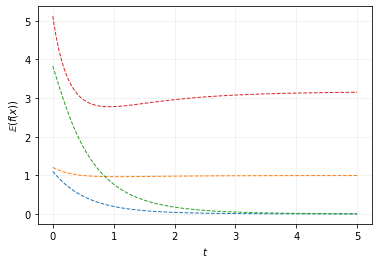

In [46]:
# plt.figure(figsize=(9,5),dpi=200)
for p in [1,2,3,4]:
    N = len(X_s)
    f = X_s[:,0]**p
    a = (1/N)*(f @ phi)
    plt.plot(np.linspace(0,5,100),csol @ a,'--',label=f'$f(x) = x^{p}$',lw=1)
plt.grid(alpha=0.2)
plt.xlabel('$t$')
plt.ylabel('$\mathbb{E}(f(x))$')